In [ ]:
import gdown
import torch
import torchvision
import os
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import numpy as np
import glob
import cv2

RuntimeError: ignored

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [35]:
!nvidia-smi

Fri May 27 00:40:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    30W /  70W |   4420MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 파라미터 설정

In [ ]:
CFG = {
    'IMG_SIZE':224, #이미지 사이즈
    'EPOCHS':150, #에포크
    'LEARNING_RATE':0.0001, #학습률
    'BATCH_SIZE':16, #배치사이즈
    'SCHEDULER':6,
    'PATIENCE':14
}

# 데이터 적제

In [ ]:
## google drive에서 압축된 dataset download
url = 'https://drive.google.com/uc?id=1e_mqtQxew8bGOwtf1I2JvtlJIQ0CSUU8'
fname = 'plant-pathology.zip'
gdown.download(url, fname, quiet=False)
!unzip plant-pathology.zip -d plant-pathology

Downloading...
From: https://drive.google.com/uc?id=1e_mqtQxew8bGOwtf1I2JvtlJIQ0CSUU8
To: /content/plant-pathology.zip
100%|██████████| 817M/817M [00:17<00:00, 46.5MB/s]


Archive:  plant-pathology.zip
  inflating: plant-pathology/images/Test_0.jpg  
  inflating: plant-pathology/images/Test_1.jpg  
  inflating: plant-pathology/images/Test_10.jpg  
  inflating: plant-pathology/images/Test_100.jpg  
  inflating: plant-pathology/images/Test_1000.jpg  
  inflating: plant-pathology/images/Test_1001.jpg  
  inflating: plant-pathology/images/Test_1002.jpg  
  inflating: plant-pathology/images/Test_1003.jpg  
  inflating: plant-pathology/images/Test_1004.jpg  
  inflating: plant-pathology/images/Test_1005.jpg  
  inflating: plant-pathology/images/Test_1006.jpg  
  inflating: plant-pathology/images/Test_1007.jpg  
  inflating: plant-pathology/images/Test_1008.jpg  
  inflating: plant-pathology/images/Test_1009.jpg  
  inflating: plant-pathology/images/Test_101.jpg  
  inflating: plant-pathology/images/Test_1010.jpg  
  inflating: plant-pathology/images/Test_1011.jpg  
  inflating: plant-pathology/images/Test_1012.jpg  
  inflating: plant-pathology/images/Test_101

파라미터 설정

## train.csv 전처리

- healthy = 0
- multiple_diseases = 1
- rust = 2
- scab = 3

In [ ]:
df_train = pd.read_csv('./plant-pathology/train.csv')
df_train

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [ ]:
df_train.loc[df_train['healthy'] == 1, 'label'] = 0
df_train.loc[df_train['multiple_diseases'] == 1, 'label'] = 1
df_train.loc[df_train['rust'] == 1, 'label'] = 2
df_train.loc[df_train['scab'] == 1, 'label'] = 3
df_train['label'] = df_train['label'].apply(lambda x : int(x))
df_train.drop(['healthy', 'multiple_diseases', 'rust', 'scab'], inplace=True, axis=1)

In [ ]:
df_train.head()

,image_id,label
0,Train_0,3
1,Train_1,1
2,Train_2,0
3,Train_3,2
4,Train_4,0


# img path 가져오기

In [ ]:
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, 'Train_*.jpg')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(df_train['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, 'Test_*.jpg')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))

    
    return img_path_list

In [ ]:
all_img_path, all_label = get_train_data('./plant-pathology/images')
test_img_path = get_test_data('./plant-pathology/images')

In [ ]:
print(len(all_img_path), len(all_label), len(test_img_path))
print(all_label[0:5])

1821 1821 1821
[3, 1, 0, 2, 0]


## 이미지 경로 -> 이미지로 변환

In [ ]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from PIL import Image

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = Image.open(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

## 훈련 데이터셋 분리 (0.75):(0.25)

In [ ]:
train_len = int(len(all_img_path)*0.75) # train 0.75
valid_len = int(len(all_img_path)*0.25)  # valid 0.25

# 데이터 분리
train_img_path = all_img_path[:train_len] 
train_label = all_label[:train_len]

# 정답 분리
valid_img_path = all_img_path[train_len:]
valid_label = all_label[train_len:]

In [ ]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', valid_len)

train set 길이 :  1365
vaildation set 길이 :  455


- train 1365
- valid 455

# RGB 값의 mean과 std를 구한다.

In [ ]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=transforms.ToTensor())
val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=transforms.ToTensor())

In [ ]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

test_meanR = np.mean([m[0] for m in train_meanRGB])
test_meanG = np.mean([m[1] for m in train_meanRGB])
test_meanB = np.mean([m[2] for m in train_meanRGB])
test_stdR = np.mean([s[0] for s in train_stdRGB])
test_stdG = np.mean([s[1] for s in train_stdRGB])
test_stdB = np.mean([s[2] for s in train_stdRGB])

In [ ]:
train_transform = transforms.Compose([
                    transforms.ToPILImage(), #Numpy배열에서 PIL이미지로
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), #이미지 사이즈 변형
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomCrop(224, padding=4),
                    transforms.ToTensor(), #이미지 데이터를 tensor
                    transforms.Normalize(mean=(train_meanR, train_meanG, train_meanB), std=(train_stdR, train_stdG, train_stdB)) #이미지 정규화
                    ])

vali_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomCrop(224, padding=4),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(test_meanR, test_meanG, test_meanB), std=(test_stdR, test_stdG, test_stdB))
                    ])

test_transform = transforms.Compose([transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                                     transforms.ToTensor()])

# 이미지 간단하게 텐서 변경(나중에 추가 예정)

In [ ]:
train_transform = transforms.Compose([transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                                      transforms.ToTensor()
                                    ])
vali_transform = transforms.Compose([transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                                      transforms.ToTensor()
                                    ])
test_transform =transforms.Compose([transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])), transforms.ToTensor()])

In [ ]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 

val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=vali_transform) 

test_ds = CustomDataset(test_img_path, valid_label, train_mode=False, transforms=test_transform) 

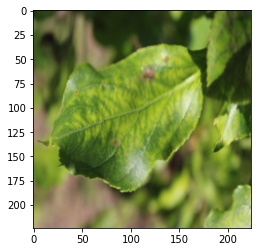

Label: 3


In [ ]:
train_features, train_labels = train_ds[0] #iter는 반복 가능한 객체에서 이터레이터를 반환하고, 
                                                        #next는 이터레이터에서 값을 차례대로 꺼냅니다. 
img = train_features
label = train_labels
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [ ]:
train_loader = DataLoader(train_ds, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) 
vali_loader = DataLoader(val_ds, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
print(len(train_loader), len(vali_loader))
print(type(train_loader), type(vali_loader))

86 29
<class 'torch.utils.data.dataloader.DataLoader'> <class 'torch.utils.data.dataloader.DataLoader'>


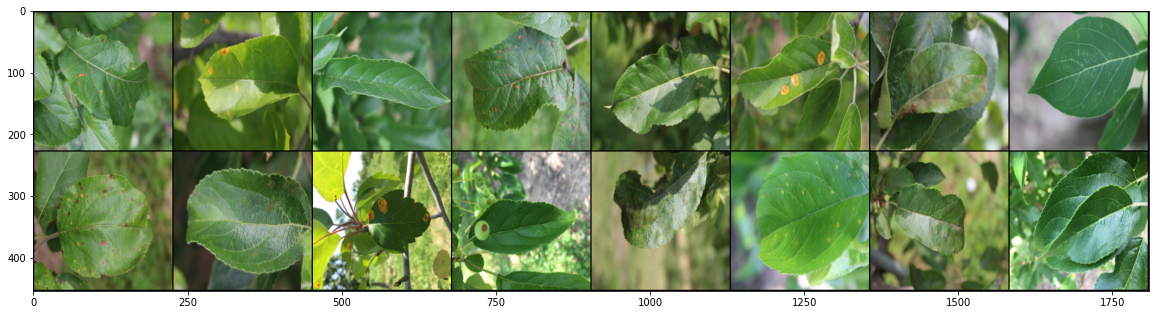

In [ ]:
def imshow(img):         
    #img = img * 0.5 + 0.5 #unnormalize (normalize : (data - 0.5)/0.5))
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(train_loader)
images, labels = dataiter.next() # 32개의 image, 32개의 label

imshow(torchvision.utils.make_grid(images, nrows=8))

# 모델 생성

RuntimeError: ignored

In [24]:
from torch import nn
from torch import optim
from torch.nn.modules.dropout import Dropout
import torch.nn.functional as F

cfg = [64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M']

class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),            
            nn.MaxPool2d(kernel_size=2, stride=2)
        )    

        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),            
            nn.MaxPool2d(kernel_size=2, stride=2)
        )   

        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),            
            nn.MaxPool2d(kernel_size=2, stride=2)
        )  # 512 * 7 * 7
        
        self.avgpool = nn.AvgPool2d(7, 7)

        self.classifier = nn.Sequential(            
            nn.Linear(in_features=512, out_features=64),             
            nn.LeakyReLU(),                     
            nn.Dropout(0.3),
            nn.Linear(in_features=64, out_features=2),            
        )
       
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        #x = x.view(-1, 512)
        x = torch.flatten(x, 1) # 1번 dim부터 펼침
        x = self.classifier(x)
        return x
    

In [38]:
from torchsummary import summary
summary(model, (3, 224, 224))

RuntimeError: ignored

In [34]:
model = VGG16()
model.to(device) # model을 GPU로 보내기

RuntimeError: ignored

# 모델 훈련

In [27]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score
writer = SummaryWriter()

def validation(model, testloader, criterion):
    test_accuracy = 0
    test_loss = 0
    true_onehot_list = []
    pred_list = []
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # Not Flatten!!!
            #images.resize_(images.shape[0], 784) # batch size x 784
            
            logits = model.forward(images) # 입력 : batch_size, 28, 28
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            probs = F.softmax(logits, dim=1)
            
            true_onehot = torch.eye(4)[labels].cpu().numpy()
            preds_ = torch.softmax(logits.cpu(), dim=1).numpy()

            pred_list.extend(preds_)
            true_onehot_list.extend(true_onehot)
            
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy
        test_auc = roc_auc_score(true_onehot_list, pred_list)
    return test_loss, test_accuracy, test_auc     

In [28]:
learning_rate = CFG['LEARNING_RATE']
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=CFG['SCHEDULER'], factor=0.1, verbose=True)

In [29]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

vali_acc=[]
vali_loss=[]

def train(model, epochs, criterion, optimizer):
    global vali_acc, vali_loss
    steps = 0
 
    # 1 에폭(epoch)당 반복수
    #iter_per_epoch = len(trainset) / batch_size  
    iter_per_epoch = len(train_loader) 
    print_every = iter_per_epoch
    best_accuracy = 0
    valid_accuracy = 0

    # for Early stopping
    min_loss = 1000
    trigger = 0
    patience = CFG['PATIENCE']

    # learning
    valid_loss = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in tqdm(iter(train_loader)):
            steps += 1
            images, labels = images.to(device), labels.to(device)

            
            optimizer.zero_grad()

            # 1. Forward (Loss 얻게됨)
            output = model.forward(images)
            loss = criterion(output, labels)

            # 2. Backward (Gradient가 오차역전파로 구해짐)
            loss.backward()

            # 3. Gradient Descent (Model parameter update) :  W <- W-lr*Gradient
            optimizer.step() 

            train_loss += loss.item() # 1 epoch 당 누적된 로스
            
            if steps % print_every == 0 : 
                 # 배치 정규화, 드롭아웃 이 적용될 경우 model.forward 연산이 training 때와 다르므로 반드시 설정
                model.eval()
                valid_loss, valid_accuracy, test_auc = validation(model, vali_loader, criterion)
                
                vali_acc.append(valid_accuracy/len(vali_loader))
                vali_loss.append(valid_loss/len(vali_loader))

                writer.add_scalar("Loss/train", train_loss/len(train_loader), epoch)
                writer.add_scalar("Loss/test", valid_loss/len(vali_loader), epoch)
                writer.add_scalars("Loss/train and valid",
                                { "train" : train_loss/len(train_loader),
                                    "test" : valid_loss/len(vali_loader) }, epoch)
                writer.add_scalar("test_roc_auc", test_auc, epoch)

                print("Epoch : {}/{}...".format(epoch+1, epochs),
                    " Train Loss : {:.3f}".format(train_loss/len(train_loader) ),
                    " Valid Loss : {:.3f}".format(valid_loss/len(vali_loader)),
                    " Valid Accuracy : {:.3f}".format(valid_accuracy/len(vali_loader)),
                    " Valid AUC_ROC :  {:.3f}".format(test_auc))
                
                # Early stopping Start 
                if valid_loss > min_loss: 
                    trigger +=1
                    print("trigger :", trigger)
                    if trigger > patience: 
                        print("Early Stopping!!!")
                        print("Train step is finished!!")
                        writer.flush()
                        writer.close() 
                        return
                else: 
                    min_loss = valid_loss
                    trigger = 0
                
                # Early stopping End
                train_loss = 0
                model.train()
            # Best model 저장
            if valid_accuracy > best_accuracy:
                torch.save(model.state_dict(), "./best_model_VGG16.pth")
                best_accuracy = valid_accuracy
            

        # Learning Rate Scheduler 
        scheduler.step(valid_loss)
    writer.flush()
    writer.close()        

In [33]:
train(model, CFG['EPOCHS'], criterion, optimizer)

  0%|          | 0/86 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

# 모델 평가

In [ ]:
def evaluate(model, testloader):
    test_accuracy = 0
    test_loss = 0
    true_onehot_list = []
    pred_list = []
    model.eval()
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device)
            # not Flatten!
            #images.resize_(images.shape[0], 784) # batch size x 784
            logits = model.forward(images) # 입력 : batch * height * width
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            true_onehot = torch.eye(4)[labels].cpu().numpy()
            preds_ = torch.softmax(logits.cpu(), dim=1).numpy()

            pred_list.extend(preds_)
            true_onehot_list.extend(true_onehot)

            probs = F.softmax(logits, dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy.item()

        test_auc = roc_auc_score(true_onehot_list, pred_list)
    print("Test Loss : ", test_loss/len(testloader))
    print("Accuracy : ", test_accuracy/len(testloader))
    print("AUC_ROC : ", test_auc)

In [ ]:
# 마지막 학습결과를 저장 후 나중에 사용하기 원할 때
torch.save(model.state_dict(), "last_checkpoint_VGG16.pth")
state_dict = torch.load("last_checkpoint_VGG16.pth") 
last_model = VGG16() # 이미 model에 마지막 학습결과가 있으나 last_model로 다시 불러옴
last_model.to(device)
last_model.load_state_dict(state_dict) # model과 parameter를 매치 시키는 작업
evaluate(last_model, test_loader)

In [ ]:
# Test Accuracy 기준으로 가장 높을때의 모델 파라미터가 저장되어 있음
state_dict = torch.load("best_checkpoint_VGG16.pth") 
best_model = VGG16()
best_model.to(device)
best_model.load_state_dict(state_dict)
evaluate(best_model, test_loader)